In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from ortools.linear_solver import pywraplp
import pandas as pd
from handlers import *

In [2]:
cities_names = [
                "Constantinople",
                "Antioch",
                "Ravenna",
                "Ephesus",
                "Carthage",
                "Alexandria",
                "Amorium",
                "Athens",
                "Milan",
                "Thessalonika",
                "Mystras"
                ]

In [3]:
G = nx.petersen_graph()
number_of_nodes = len(G.nodes())

pos = nx.shell_layout(G)

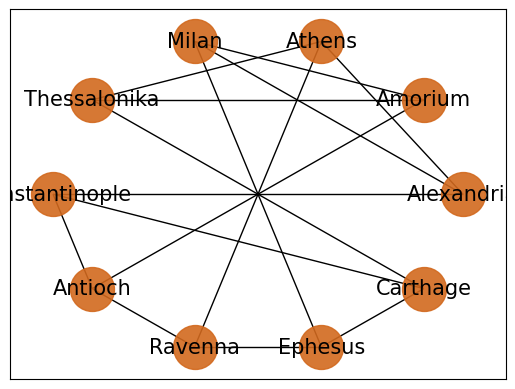

In [4]:
labels = {n:cities_names[n] for n in range(number_of_nodes)}

nx.draw_networkx_nodes(G, pos, node_color="chocolate", node_size=1000, alpha=0.9)
nx.draw_networkx_edges(G, pos)
x = nx.draw_networkx_labels(G, pos, labels, font_size=15)

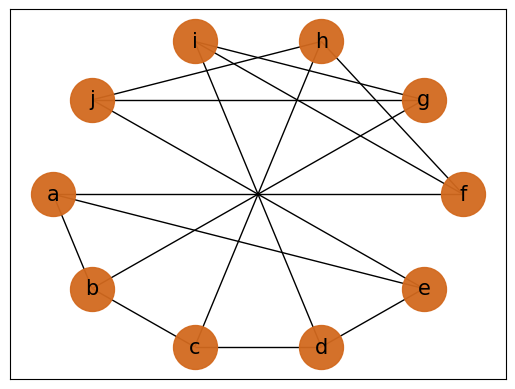

In [5]:
labels = {n:generate_index_label(n) for n in range(number_of_nodes)}

nx.draw_networkx_nodes(G, pos, node_color="chocolate", node_size=1000, alpha=0.95)
nx.draw_networkx_edges(G, pos)
x = nx.draw_networkx_labels(G, pos, labels, font_size=15)

In [6]:
rr_solver = pywraplp.Solver.CreateSolver('SAT')

In [7]:
y = [rr_solver.IntVar(0.0, 1.0, 'y{}'.format(i)) for i in range(number_of_nodes)]
x = [rr_solver.NumVar(0.0, rr_solver.infinity(), 'x{}'.format(i)) for i in range(number_of_nodes)]

In [8]:
rr_solver.Minimize(rr_solver.Sum(x[i]+y[i] for i in range(number_of_nodes)))

In [9]:
for i in range(number_of_nodes):
    rr_solver.Add(x[i] + rr_solver.Sum(y[j[1]] for j in G.edges(i)) >= 1)

In [10]:
for i in range(number_of_nodes):
    rr_solver.Add(y[i] <= x[i])

In [11]:
rr_status = rr_solver.Solve()

In [12]:
if rr_status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', rr_solver.Objective().Value())

    nodes_colors = []
    for i in range(number_of_nodes):
        if (y[i].solution_value() > 0):
            nodes_colors.append("greenyellow")
        elif (x[i].solution_value() > 0):
            nodes_colors.append("lightsteelblue")
        else:
            nodes_colors.append("chocolate")

else:
    print('The problem does not have an optimal solution.')

Solution:
Objective value = 6.0


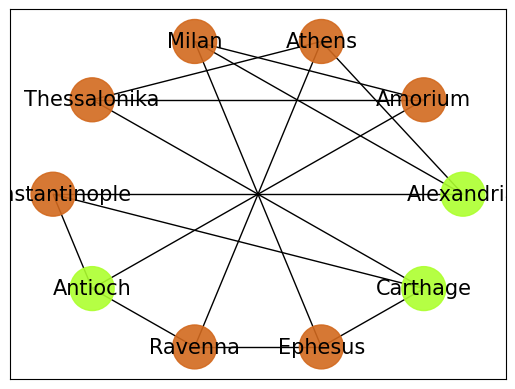

In [13]:
#nx.draw(G, pos=pos, node_color=nodes_colors, with_labels=True)    
labels = {n:cities_names[n] for n in range(number_of_nodes)}

nx.draw_networkx_nodes(G, pos, node_color=nodes_colors, node_size=1000, alpha=0.9)
nx.draw_networkx_edges(G, pos)
x = nx.draw_networkx_labels(G, pos, labels, font_size=15)

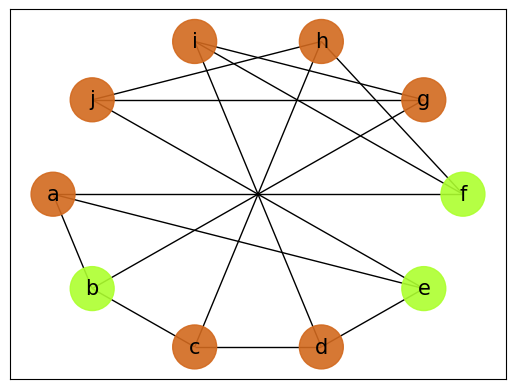

In [14]:
labels = {n:generate_index_label(n) for n in range(number_of_nodes)}

nx.draw_networkx_nodes(G, pos, node_color=nodes_colors, node_size=1000, alpha=0.9)
nx.draw_networkx_edges(G, pos)
x = nx.draw_networkx_labels(G, pos, labels, font_size=15)

In [18]:
fabio_df = pd.DataFrame(columns=["graph_type", "size", "probabilities", "objective_value", "time_ms", "iterations", "branch_and_bound_nodes"])

In [19]:
nodes_quantities = [10, 20, 40, 80, 100]
edges_probabilities = [0.5, 0.8]

for u in range(1):
    for n in nodes_quantities:
        for p in edges_probabilities:
            solver = get_rr_imp_solver(nx.gnp_random_graph(n,p), n)
            solver.set_time_limit(30*60*1000)      
            status = solver.Solve()
                        
            if status == pywraplp.Solver.OPTIMAL:
                fabio_df.loc[len(fabio_df.index)] = [
                    "gnp_random_graph",
                    n,
                    p,
                    solver.Objective().Value(),
                    solver.wall_time(),
                    solver.iterations(),
                    solver.nodes()
                ]
                        
            else:
                raise ValueError('The problem does not have an optimal solution.')
        
fabio_df.to_csv("./data/fabio_rr_imp_results.csv", index=False, header=False)